In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.linalg import solve_sylvester, norm
import os
from sklearn.metrics import f1_score
import json
import pandas as pd

Data generation

In [35]:
def ensure_positive_definite(M, epsilon=1e-1, min_threshold=1e-3):
    """Ensure M is well-conditioned ; add small value to diagonal if needed"""
    min_eig = np.min(np.linalg.eigvals(M))
    
    if min_eig < min_threshold:
        print(f"Minimum eigenvalue too small ({min_eig:.2e}), adding {epsilon} to diagonal elements.")
        M += np.eye(M.shape[0]) * (abs(min_eig) + epsilon)
        
    min_eig = np.min(np.linalg.eigvals(M))
    print(f"Minimum eigen value after adding to diagonal: {min_eig:.2e}")
    return M

In [36]:
def make_d_diagonal_spd_matrix(
        n_dim=10,
        d=3, 
        smallest_coef=0.1,
        largest_coef=0.9,
        random_state=None
):
    """ 
    Generate a d-diagonal SPD matrix
    """

    # Ensure d is odd, otherwise raise an exception
    if d % 2 == 0:
        raise ValueError("d must be an odd number.")

    rng = np.random.default_rng(random_state)

    # Initialize diagonal
    diag = np.ones(n_dim)

    # Initialize matrix
    m = np.diag(diag)

    # Fill subdiagonal and superdiagonal values symmetrically
    half_bandwidth = (d - 1) // 2
    for w in range(1, half_bandwidth + 1):  # 1st, 2nd, ..., half_bandwidth diagonals
        for i in range(n_dim - w):
            temp = rng.uniform(low=smallest_coef, high=largest_coef)
            m[i + w, i] = temp
            m[i, i + w] = temp  # Maintain symmetry

    # Ensure positive definiteness
    return ensure_positive_definite(m)


Minimum eigenvalue too small (-3.23e-01), adding 0.1 to diagonal elements.
Minimum eigen value after adding to diagonal: 1.00e-01


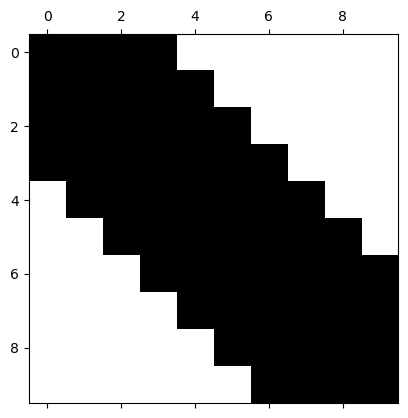

In [37]:
plt.spy(make_d_diagonal_spd_matrix(d=7)) # check if its giving 

In [38]:
def generate_sparse_covariance(B, sample_scaling=1.0):
    """
    Generate a sparse inverse covariance matrix B, compute its associated covariance matrix E,
    and generate samples from a multivariate normal distribution with covariance E.

    Parameters:
    - n (int): Dimension of the matrix.
    - sample_scaling (float): Scaling factor for the number of samples (N = sample_scaling * d^2 log2(n)).
    - random_state (int): Random seed for reproducibility.

    Returns:
    - S (np.ndarray): Sample covariance matrix from the generated samples.
    - N (int): Computed number of samples.
    """
    # Create sparse PSD matrix (B)
    # B = make_tridiagonal_spd_matrix(n_dim=n, random_state= random_state)
    n = len(B)

    # Compute degree d as the maximum number of nonzero entries per row in B (excluding diagonal)
    d = np.max(np.sum(B != 0, axis=1)) - 1  # Exclude diagonal elements
    print("Max degree in B", d)

    # Compute the required number of samples with log 
    N = int(sample_scaling * ((d*d) * np.log(n)))
    # N = max(N, n)  # Ensure N is at least n for stability

    # Compute true inverse covariance matrix (Strue)
    Strue = np.linalg.matrix_power(B, 2)

    # Compute covariance matrix (E)
    E = np.linalg.inv(Strue)

    # Generate N samples Y ~ N(0, E)
    y_samples = la.sqrtm(E).dot(np.random.randn(n, N))

    # Calculate sample covariance matrix
    S = np.cov(y_samples)

    return S, N

Minimum eigenvalue too small (-3.19e-01), adding 0.1 to diagonal elements.
Minimum eigen value after adding to diagonal: 1.00e-01
Max degree in B 2
Number of samples 921
F1 norm 2.1173058151693507


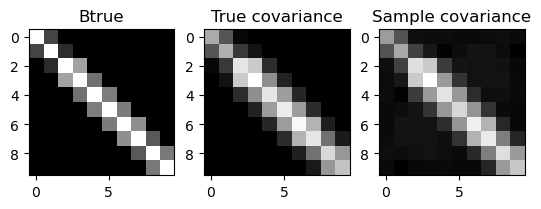

In [46]:
B = make_d_diagonal_spd_matrix()
S, N = generate_sparse_covariance(B, sample_scaling=100)
plt.subplot(1,3, 1)
plt.imshow(B, cmap = 'gray')
plt.title("Btrue")
plt.subplot(1,3,2)
plt.imshow(B@B, cmap = 'gray')
plt.title("True covariance")
plt.subplot(1,3,3)
plt.imshow(np.linalg.inv(S), cmap = 'gray')
plt.title("Sample covariance")
print("Number of samples", N)
print("F1 norm", np.linalg.norm(np.linalg.inv(B@B)-S, ord="fro"))

Algorithm

In [47]:
def newton_nare(A, B, C, D, X0, tol=1e-13, kmax=30):
    """
    Newton's method for solving the Nonlinear Algebraic Riccati Equation (NARE):
    C + XA + DX - XBX = 0
    """
    X = X0.copy()
    k = 0
    err = 1

    while err > tol and k < kmax:
        # Compute residual RX = C + XA + DX - XBX
        RX = C + X @ A + D @ X - X @ B @ X

        # Solve the Sylvester equation (D - XB)H + H(A - BX) = -RX for H
        H = solve_sylvester(D - X @ B, A - B @ X, -RX)

        # Update X
        X = X + H

        # Calculate the error; changed from l1 to frobenius
        err = norm(H, 1) / norm(X, 1)
        # err = norm(H, 'fro') / (1 + norm(X, 'fro'))

        if k % 5 == 0:  # Print every 5 iterations
            print(f"Iteration {k}, Error: {err:.2e}")
        
        # Increment iteration counter
        k += 1

    # Check if the solution converged
    if k == kmax:
        print("Warning: reached the maximum number of iterations without convergence.")

    return X

In [48]:
# Soft thresholding function
def soft_thresholding(x, threshold):
    """Applies soft-thresholding elementwise."""
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

In [49]:
def soft_thresholding_offdiag(B_new, Lambda, lambda_, rho):
    """
    Applies off-diagonal soft-thresholding.
    """
    
    # Compute argument for soft-thresholding
    X = rho * B_new + Lambda
    
    # Create a copy to modify
    Z_new = X.copy()
    
    # Off-diagonal mask
    mask_offdiag = ~np.eye(X.shape[0], dtype=bool)

    # Apply soft-thresholding only to off-diagonal elements
    Z_new[mask_offdiag] = np.sign(X[mask_offdiag]) * np.maximum(np.abs(X[mask_offdiag]) - lambda_, 0)

    return Z_new


In [50]:
# ADMM Algorithm for Elastic-Net Penalized Precision Matrix Estimation
def admm_precision_matrix(S, lambda_, rho=1.0, max_iter=100, tol=1e-4):
    """
    ADMM algorithm for precision matrix estimation with elastic-net penalty.
    """
    n = S.shape[0]
    Z = np.zeros((n, n))
    Lambda = np.zeros((n, n))
    I = np.eye(n)  # Identity matrix

    # Initial B (can be initialized as identity matrix)
    B = np.eye(n)

    for k in range(max_iter):
        # Step 1: Update B using Newton NARE
        # Here, we set up the matrices to solve the NARE: A3 + XA1 + A4X - XA2X = 0
        A3 = - 2 * I
        A4 = Lambda - rho * Z
        A1 = 0 * I
        A2 = - (2 * S + rho * I)
        X0 = B  # Initial guess for Newton NARE

        # Solve for the new B using Newton NARE
        B_new = newton_nare(A1, A2, A3, A4, X0)

        # Step 2: Update Z elementwise using soft-thresholding
        Z_new = soft_thresholding(rho * B_new + Lambda, lambda_)
        Z_new = Z_new / rho

        # Step 3: Update Lambda (Lagrange multiplier)
        Lambda_new = Lambda + rho * (B_new - Z_new)

        # print(f"ADMM update loss: ", np.linalg.norm(B_new - B, ord='fro') )
        # Check convergence
        if np.linalg.norm(B_new - B, ord='fro') < tol:
            print(f"ADMM Converged after {k+1} iterations.")
            break
        elif k == max_iter-1 :
            print(f"ADMM failed to converge after {k+1} iterations.")

        # Update for the next iteration
        B, Z, Lambda = B_new, Z_new, Lambda_new      

    return B

In [51]:
#Thresholding B_estimate
def hard_threshold(B_estimate,threshold):
  return np.where(np.abs(B_estimate) > threshold, B_estimate, 0)

Simple experiment

In [52]:
B = make_d_diagonal_spd_matrix(n_dim= 30, d=5)

Minimum eigenvalue too small (-5.55e-01), adding 0.1 to diagonal elements.
Minimum eigen value after adding to diagonal: 1.00e-01


In [53]:
S, N = generate_sparse_covariance(B, sample_scaling=1.0)
# Parameters for the elastic-net penalty and ADMM algorithm
lambda_ = 0.166  # Regularization strength
alpha = 1  # Mixing parameter (0 = Ridge, 1 = Lasso)
rho = 1.0  # ADMM penalty parameter
max_iter = 200  # Maximum number of iterations
tol = 1e-4  # Convergence tolerance

# Run the ADMM algorithm using the generated sample covariance matrix
B_estimate = admm_precision_matrix(S, lambda_, rho, max_iter, tol)

print("Estimated Precision Matrix (B estimate):")
print(B_estimate)

Max degree in B 4
Iteration 0, Error: 5.70e-01
Iteration 5, Error: 2.21e-04
Iteration 0, Error: 1.36e-01
Iteration 0, Error: 2.49e-01
Iteration 5, Error: 3.22e-15
Iteration 0, Error: 1.33e-01
Iteration 0, Error: 9.38e-02
Iteration 0, Error: 6.21e-02
Iteration 0, Error: 4.14e-02
Iteration 0, Error: 2.77e-02
Iteration 0, Error: 2.03e-02
Iteration 0, Error: 1.47e-02
Iteration 0, Error: 1.00e-02
Iteration 0, Error: 7.97e-03
Iteration 0, Error: 5.60e-03
Iteration 0, Error: 4.39e-03
Iteration 0, Error: 2.97e-03
Iteration 0, Error: 2.48e-03
Iteration 0, Error: 1.73e-03
Iteration 0, Error: 1.28e-03
Iteration 0, Error: 1.08e-03
Iteration 0, Error: 9.38e-04
Iteration 0, Error: 1.49e-03
Iteration 0, Error: 1.18e-03
Iteration 0, Error: 1.20e-03
Iteration 0, Error: 8.32e-04
Iteration 0, Error: 6.25e-04
Iteration 0, Error: 4.57e-04
Iteration 0, Error: 3.84e-04
Iteration 0, Error: 3.42e-04
Iteration 0, Error: 3.05e-04
Iteration 0, Error: 3.16e-04
Iteration 0, Error: 2.89e-04
Iteration 0, Error: 2.54e

Text(0.5, 1.0, 'B estimate - 1e-2 tres')

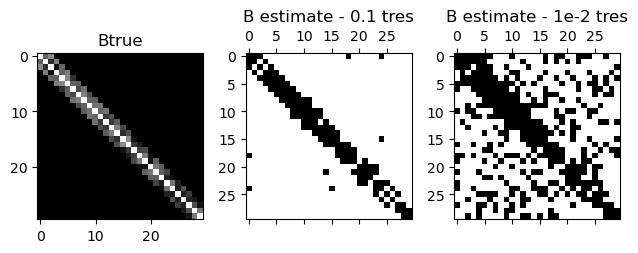

In [54]:
plt.subplot(1,3, 1)
plt.imshow(B, cmap= "gray")
plt.title("Btrue")
plt.subplot(1,3,2)
# plt.imshow(hard_threshold(B_estimate, 0.2), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 0.1))
plt.title("B estimate - 0.1 tres")
plt.subplot(1,3,3)
# plt.imshow(hard_threshold(B_estimate, 0.4), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 1e-2))
plt.tight_layout()
plt.title("B estimate - 1e-2 tres")

Experimentation

In [61]:
def evaluate_f1_vs_lambda(
        lambda_values, B, sample_scaling=1.0,
        rho=1.0, max_iter=100, tol=1e-4,
        threshold=1e-4, save_plots = False, log_dir="experiment_logs"):
    """
    Evaluate f1 scores, 
    excluding diagonal elements, for each lambda.
    """
    
    B = np.array(B)
    n = B.shape[0]
    
    # Generate sample covariance S and sample size N
    S, N = generate_sparse_covariance(B, sample_scaling=sample_scaling)

    print("Number of samples:", N)
    print("Minimum eigenvalue of B:", np.min(np.linalg.eigvals(B)))

    # Ground-truth adjacency (full)
    ground_truth_adjacency = (B != 0).astype(int)

    # Exclude diagonals via a mask
    mask_offdiag = ~np.eye(n, dtype=bool)

    metrics = {
        "lambda": [],
        "f1": [],
    }

    for lambda_ in lambda_values:
        # Estimate precision matrix with user-defined ADMM function
        B_est = admm_precision_matrix(S, lambda_, rho, max_iter, tol)

        # Threshold the estimate
        B_est_thresholded = hard_threshold(B_est, threshold)

        if save_plots:
            # Plot and save the sparsity patterns (optional, can remove if not needed)
            plt.figure(figsize=(6, 12))
            
            plt.subplot(1, 2, 1)
            plt.spy(B)
            plt.title("B (True)", fontsize=16)

            plt.subplot(1, 2, 2)
            plt.spy(B_est_thresholded)
            plt.title("B_est (Estimated)", fontsize=16)

            plot_path = os.path.join(log_dir, f"sparsity_lambda_{lambda_:.3f}.png")
            plt.savefig(plot_path)
            plt.close()
            
        
        predicted_adjacency = (B_est_thresholded != 0).astype(int)
        gt_offdiag = ground_truth_adjacency[mask_offdiag]
        pred_offdiag = predicted_adjacency[mask_offdiag]

        f1 = f1_score(gt_offdiag, pred_offdiag)

        # Store the results
        metrics["lambda"].append(lambda_)
        metrics["f1"].append(f1)

    return metrics

In [108]:
# Updated main loop
n = 30
sample_scaling = 10.0
d = 7
B = make_d_diagonal_spd_matrix(n_dim= n, d = d)

log_dir = f"experiment_logs/{d}/n_{n}_scale_{sample_scaling}"
# Create a directory to save logs if it doesn’t exist
os.makedirs(log_dir, exist_ok=True)

# params
args = {
    "lambda_values": np.linspace(0,0.4, 30).tolist(),
    "B": B.tolist(),
    "sample_scaling": sample_scaling,
    "rho": 1.0,
    "max_iter": 200,
    "tol": 1e-4,
    "threshold": 1e-1,
    "log_dir": log_dir
}
print(f"Evaluating metrics for {args}")

# Save args to a JSON file (for reproducibility)
json_path = os.path.join(log_dir, "params.json")
with open(json_path, "w") as json_file:
    json.dump(args, json_file, indent=4)

# Call our updated evaluate_metrics_vs_lambda
metrics = evaluate_f1_vs_lambda(**args)

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Save metrics to CSV or Excel
csv_path = os.path.join(log_dir, "metrics.csv")
metrics_df.to_csv(csv_path, index=False)

# Pick best lambda by F1
best_idx = metrics_df["f1"].idxmax()
best_f1 = metrics_df["f1"].max()
best_lambda = metrics_df.loc[best_idx, "lambda"]
print(f"Best f1 scores = {best_f1}")
print(f"Best lambda by f1 = {best_lambda:.3f}")

# Plot all metrics vs. lambda
plt.figure(figsize=(8, 6))
plt.plot(metrics_df["lambda"], metrics_df["f1"])

plt.xlabel("Lambda")
plt.ylabel("F1 score")
plt.title("Metrics vs. F1")
plt.legend()
plot_path = os.path.join(log_dir, "f1_vs_lambda.png")
plt.savefig(plot_path)
plt.close()


Minimum eigenvalue too small (-6.88e-01), adding 0.1 to diagonal elements.
Minimum eigen value after adding to diagonal: 1.00e-01
Evaluating metrics for {'lambda_values': [0.0, 0.013793103448275864, 0.027586206896551727, 0.04137931034482759, 0.055172413793103454, 0.06896551724137932, 0.08275862068965519, 0.09655172413793105, 0.11034482758620691, 0.12413793103448277, 0.13793103448275865, 0.1517241379310345, 0.16551724137931037, 0.17931034482758623, 0.1931034482758621, 0.20689655172413796, 0.22068965517241382, 0.23448275862068968, 0.24827586206896554, 0.2620689655172414, 0.2758620689655173, 0.2896551724137931, 0.303448275862069, 0.31724137931034485, 0.33103448275862074, 0.3448275862068966, 0.35862068965517246, 0.3724137931034483, 0.3862068965517242, 0.4], 'B': [[1.7881130868534143, 0.6688786740582993, 0.6467146964948697, 0.8472600611366076, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.668878674058299

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Iteration 0, Error: 3.72e-04
Iteration 0, Error: 3.25e-04
Iteration 0, Error: 2.97e-04
Iteration 0, Error: 2.77e-04
Iteration 0, Error: 2.60e-04
Iteration 0, Error: 2.46e-04
Iteration 0, Error: 2.34e-04
Iteration 0, Error: 2.23e-04
Iteration 0, Error: 2.13e-04
Iteration 0, Error: 2.03e-04
Iteration 0, Error: 1.95e-04
Iteration 0, Error: 1.87e-04
Iteration 0, Error: 1.80e-04
Iteration 0, Error: 1.72e-04
Iteration 0, Error: 1.59e-04
Iteration 0, Error: 1.54e-04
Iteration 0, Error: 1.48e-04
Iteration 0, Error: 1.43e-04
Iteration 0, Error: 1.39e-04
Iteration 0, Error: 1.34e-04
Iteration 0, Error: 1.30e-04
Iteration 0, Error: 1.26e-04
Iteration 0, Error: 1.22e-04
Iteration 0, Error: 1.19e-04
Iteration 0, Error: 1.15e-04
Iteration 0, Error: 1.12e-04
Iteration 0, Error: 1.09e-04
Iteration 0, Error: 1.06e-04
Iteration 0, Error: 1.04e-04
Iteration 0, Error: 1.01e-04
Iteration 0, Error: 9.86e-05
Iteration 0, Error: 9.62e-05
Iteration 0, Error: 9.39e-05
Iteration 0, Error: 9.17e-05
Iteration 0, E

F1 vs sample scaling

In [117]:

def plot_f1_vs_sample_scaling(
    n_dim= 10, 
    best_lambda=0.194,
    d_values=[3, 5, 7, 9],
    rho=1.0,
    max_iter=200,
    tol=1e-4,
    threshold=1e-1,
    scaling_values=np.linspace(1, 30, 15),
    num_trials=10,
    log_dir="experiment_scale_logs"
):
    """
    Fix parameters (n, alpha, best_lambda, etc.) and update sample_scaling from
    to see how F1 improves with more samples for different d values
    """
    if scaling_values is None:
        scaling_values = np.arange(1, 21)
    
    
    os.makedirs(log_dir, exist_ok=True)
    
    plt.figure(figsize=(8, 6))
    
    results = []
    
    for d in d_values:
        f1_scores = []
        B = make_d_diagonal_spd_matrix(n_dim, d)

         # Ground-truth adjacency (full)
        ground_truth_adjacency = (B != 0).astype(int)
        # Exclude diagonals via a mask
        mask_offdiag = ~np.eye(n, dtype=bool)
        
        for scale in scaling_values:
            _f1_scores = []
            for i in range(num_trials):
                # Generate data with the current scale
                S, N = generate_sparse_covariance(B, sample_scaling=scale)
                
                # Estimate precision matrix using the best param config
                B_est = admm_precision_matrix(S, best_lambda, rho, max_iter, tol)
                
                # Threshold the estimate
                B_est_thresholded = hard_threshold(B_est, threshold)
                
                predicted_adjacency = (B_est_thresholded != 0).astype(int)
                gt_offdiag = ground_truth_adjacency[mask_offdiag]
                pred_offdiag = predicted_adjacency[mask_offdiag]

                f1 = f1_score(gt_offdiag, pred_offdiag)

                _f1_scores.append(f1)
            
            f1_scores.append(np.average(_f1_scores))
            print(f"d={d}, scale={scale}, #samples={N}, F1={np.average(_f1_scores):.3f}")
        
        results.append(pd.DataFrame({"sample_scaling": scaling_values, "F1": f1_scores, "d": d}))
        plt.plot(scaling_values, f1_scores, marker="o", label=f"d={d}")
    
    df = pd.concat(results, ignore_index=True)
    
    # Save to CSV
    csv_path = os.path.join(log_dir, f"f1_vs_scaling_{n}_threshold_{threshold}.csv")
    df.to_csv(csv_path, index=False)
    
    # Plot
    plt.xlabel("Sample Scaling")
    plt.ylabel("F1 Score")
    plt.title(f"F1 vs. Sample Scaling (n={n}, lambda={best_lambda}, threshold={threshold})")
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(log_dir, f"f1_vs_scaling_{n}_threshold_{threshold}.png")
    plt.savefig(plot_path)
    plt.close()
    
    return df

In [122]:
plot_f1_vs_sample_scaling(
        best_lambda=0.028,
        n_dim= 30,
        rho=1.0,
        max_iter=200,
        tol=1e-4,
        threshold=1e-1,
        scaling_values=np.linspace(1, 35, 15), 
        log_dir="f1_scale_experiment"
    )

Minimum eigenvalue too small (-3.41e-01), adding 0.1 to diagonal elements.
Minimum eigen value after adding to diagonal: 1.00e-01
Max degree in B 2
Iteration 0, Error: 6.50e-01
Iteration 5, Error: 3.47e-04
Iteration 0, Error: 4.87e-01
Iteration 5, Error: 1.17e-14
Iteration 0, Error: 3.28e-01
Iteration 5, Error: 5.58e-15
Iteration 0, Error: 2.08e-01
Iteration 5, Error: 6.99e-15
Iteration 0, Error: 1.51e-01
Iteration 0, Error: 1.18e-01
Iteration 0, Error: 9.57e-02
Iteration 0, Error: 8.07e-02
Iteration 0, Error: 6.91e-02
Iteration 0, Error: 5.99e-02
Iteration 0, Error: 5.30e-02
Iteration 0, Error: 4.77e-02
Iteration 0, Error: 4.33e-02
Iteration 0, Error: 3.93e-02
Iteration 0, Error: 3.59e-02
Iteration 0, Error: 3.30e-02
Iteration 0, Error: 3.05e-02
Iteration 0, Error: 2.83e-02
Iteration 0, Error: 2.63e-02
Iteration 0, Error: 2.46e-02
Iteration 0, Error: 2.32e-02
Iteration 0, Error: 2.20e-02
Iteration 0, Error: 2.08e-02
Iteration 0, Error: 1.95e-02
Iteration 0, Error: 1.85e-02
Iteration 0

,sample_scaling,F1,d
0,1.000000,0.163408,3
1,3.428571,0.250790,3
2,5.857143,0.475598,3
3,8.285714,0.628920,3
4,10.714286,0.786283,3
5,13.142857,0.912122,3
6,15.571429,0.953979,3
7,18.000000,0.966318,3
8,20.428571,0.981597,3
9,22.857143,0.988288,3
